[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aymgal/herculens_workspace/blob/new-param-interface/notebooks/herculens__Simple_galaxy_fitting.ipynb)

# Modeling a simple galaxy with a smooth profile

__author__: @aymgal

__last updated__: 04/04/23

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Installing requirements and dependencies
    !pip install --quiet git+https://github.com/austinpeel/herculens.git
    !pip install --quiet blackjax==0.9.6 numpyro==0.10.1 emcee==3.0.2
    !pip install --quiet jaxns dynesty getdist

In [2]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
from time import time
import numpy as np
from astropy.io import fits
from copy import deepcopy
from pprint import pprint
%matplotlib inline

import jax
import jax.numpy as jnp

# Herculens imports
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.LensImage.lens_image import LensImage
#from herculens.Parameters.parameters import Parameters
from herculens.Inference.ProbModel.numpyro import NumpyroModel
from herculens.Inference.Optimization.optax import OptaxOptimizer
from herculens.Inference.loss import Loss
#from herculens.Inference.optimization import Optimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import image_util, param_util, plot_util

# Baseline font soze
FS = 18

# Plotting engine
plotter = Plotter(base_fontsize=FS, flux_vmin=1e-3, flux_vmax=1e0, res_vmax=6)

## 1. Simulate an observation

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [3]:
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (-3.16, 3.16) arcsec
y range    : (-3.16, 3.16) arcsec


### Point spread function (PSF)

For simplicity we assume here a Gaussian PSF.

In [4]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.2}
psf = PSF(**kwargs_psf)

### Noise

In [5]:
# exposure time, used for estimating the shot noise
exp_time = 2000
# standard deviation of the background noise
sigma_bkd = 0.005

kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)

### Load the galaxy

We construct use a galaxy merger observed with HST as realistic example of a complex source.

In [6]:
light_model_input = LightModel(['SERSIC_ELLIPSE'])
amp_src = 10.
kwargs_galaxy_input = [
    {
        'amp': amp_src,
        'R_sersic': 1.,
        'n_sersic': 2.5,
        'e1': 0.1,
        'e2': -0.1,
        'center_x': 0.,
        'center_y': 0.,
    }
]

### Generate the lens image

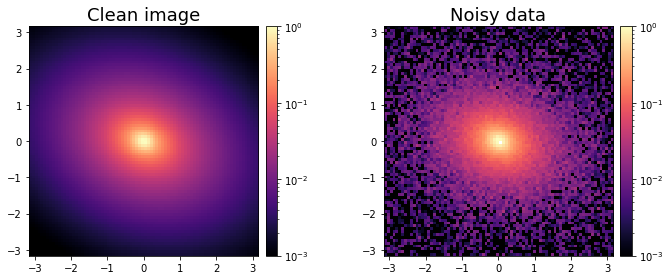

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = LensImage(pixel_grid, psf, noise_class=noise,
                            lens_light_model_class=light_model_input,
                            kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens_light=kwargs_galaxy_input)
image = lens_image_simu.model(**kwargs_all_input)

data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, noise_seed=29)

galaxy_input = lens_image_simu.lens_surface_brightness(kwargs_galaxy_input, unconvolved=True)
#extent_src = lens_image_simu.SourceModel.pixel_grid.extent

# visualize simulated products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy data", fontsize=FS)
plot_util.nice_colorbar(img2)
fig.tight_layout()
plt.show()

## 2. Surface brightness modelling

### Create a model for fitting

In [8]:
# Setup the source model: pixelated on a regular grid
light_model = LightModel(['SERSIC_ELLIPSE'])

kwargs_numerics_fit = {'supersampling_factor': 3}
lens_image = LensImage(deepcopy(pixel_grid), psf, noise_class=noise,
                       lens_light_model_class=light_model,
                       kwargs_numerics=kwargs_numerics_fit)

In [9]:
# inform the plotter of the data
plotter.set_data(data)

# inform the plotter about the true source (on the pixelated grid)
x_grid_src, y_grid_src = lens_image.Grid.pixel_coordinates
galaxy_input_fitgrid = lens_image_simu.LensLightModel.surface_brightness(x_grid_src, y_grid_src, kwargs_galaxy_input)
galaxy_input_fitgrid *= lens_image.Grid.pixel_area
plotter.set_ref_lens_light(galaxy_input_fitgrid)

In [10]:
import numpyro
import numpyro.distributions as dist
import numpyro.util as numpyro_util
from numpyro import handlers


class ProbModel(NumpyroModel):
    
    def model(self):
        # Parameters of the lens light
        prior_lens_light = [
        {'amp': numpyro.sample('light_amp', dist.Uniform(0, 100)), 
         'R_sersic': numpyro.sample('light_R_sersic', dist.Normal(kwargs_galaxy_input[0]['R_sersic'], 0.1)), 
         'n_sersic': numpyro.sample('light_n_sersic', dist.Uniform(2., 5.)), 
         'e1': numpyro.sample('light_e1', dist.TruncatedNormal(kwargs_galaxy_input[0]['e1'], 0.05, low=-0.3, high=0.3)),
         'e2': numpyro.sample('light_e2', dist.TruncatedNormal(kwargs_galaxy_input[0]['e2'], 0.05, low=-0.3, high=0.3)),
         'center_x': numpyro.sample('light_center_x', dist.Normal(kwargs_galaxy_input[0]['center_x'], 0.05)), 
         'center_y': numpyro.sample('light_center_y', dist.Normal(kwargs_galaxy_input[0]['center_y'], 0.05))}
        ]
        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens_light=prior_lens_light)
        
        # generates the model image
        model_image = lens_image.model(**model_params)
        
        # estimate the error per pixel
        model_error = jnp.sqrt(noise.C_D_model(model_image))
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_error), 2), obs=data)
    
    def params2kwargs(self, params):
        # functions that takes the flattended dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        kw = {'kwargs_lens_light': [{'amp': params['light_amp'],
        'R_sersic': params['light_R_sersic'],
        'n_sersic': params['light_n_sersic'],
        'e1': params['light_e1'], 'e2': params['light_e2'],
        'center_x': params['light_center_x'],
        'center_y': params['light_center_y']}]}
        return kw

prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)


Number of parameters: 7


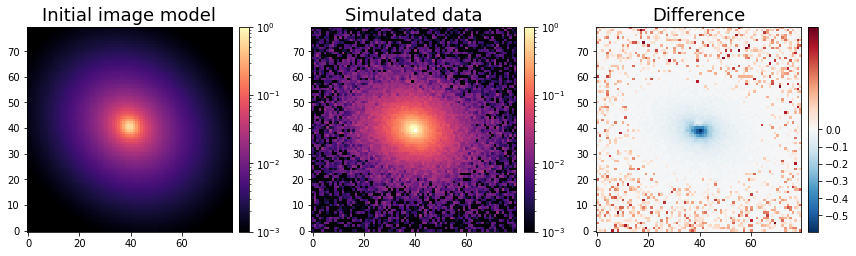

In [11]:
init_params = prob_model.get_sample(seed=76)
kwargs_init = prob_model.params2kwargs(init_params)

# visualize initial guess
initial_model = lens_image.model(**kwargs_init)


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.set_title("Initial image model", fontsize=FS)
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Simulated data", fontsize=FS)
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Difference", fontsize=FS)
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

### Loss function

In [12]:
loss = Loss(lens_image, prob_model)

print("Loss at initial values:", loss(init_params))

Loss at initial values: 779.4876


### Minimise the loss function using `optax`

We use the adaptive gradient descent algorithm AdaBelief to optimize the values of all source pixels.

In [23]:
optimizer = OptaxOptimizer(loss, loss_norm_optim=data.size)

# optimizer settings
max_iterations = 10000
init_learning_rate = 1e-3

best_fit, logL, extra_fields, runtime \
    = optimizer.run(init_params, max_iterations=max_iterations, 
                    init_learning_rate=init_learning_rate)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss(best_fit))

optax.adabelief: 100%|██████████| 10000/10000 [00:46<00:00, 215.61it/s]


Runtime: 46.38224720954895
Loss at best-fit: -24111.9


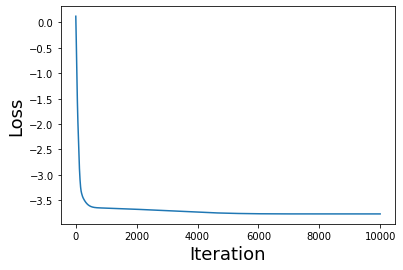

In [24]:
kwargs_bestfit = prob_model.params2kwargs(best_fit)

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

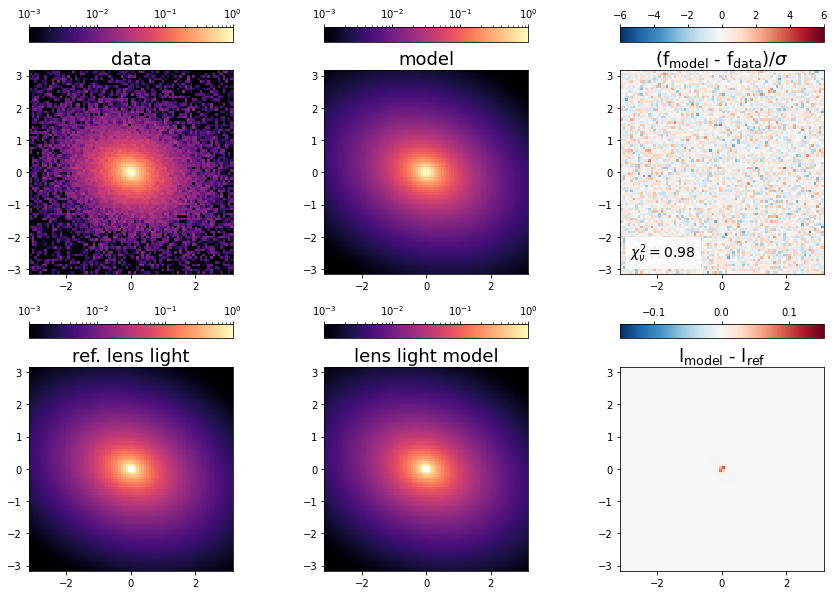

In [25]:
fig = plotter.model_summary(lens_image, kwargs_bestfit, show_source=False, show_lens_light=True)
plt.show()